# Feature Engineering and Model Training

## Feature Engineering

### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Data/nyc_taxi_weather_agg_jan_mar_2025_cleaned.csv')

In [3]:
df.head()

,pickup_hour,PULocationID,ride_count,temperature_2m,precipitation,weathercode,hour,day_of_week,month,is_weekend
0,2025-01-01 00:00:00-05:00,4,28,7.9,3.4,63,0,2,1,0
1,2025-01-01 00:00:00-05:00,7,12,7.9,3.4,63,0,2,1,0
2,2025-01-01 00:00:00-05:00,9,1,7.9,3.4,63,0,2,1,0
3,2025-01-01 00:00:00-05:00,10,1,7.9,3.4,63,0,2,1,0
4,2025-01-01 00:00:00-05:00,12,1,7.9,3.4,63,0,2,1,0


### Let us Add Holiday Flags

In [4]:
df['pickup_hour'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 322091 entries, 0 to 322090
Series name: pickup_hour
Non-Null Count   Dtype 
--------------   ----- 
322091 non-null  object
dtypes: object(1)
memory usage: 2.5+ MB


In [6]:
import holidays

us_holidays = holidays.US()
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], errors='coerce')
df['date'] = df['pickup_hour'].dt.date
df['is_holiday'] = df['date'].isin(us_holidays).astype(int)

### Now, let us generate Lag Features

In [7]:
df = df.sort_values(['PULocationID', 'pickup_hour'])

df['ride_count_lag_1'] = df.groupby('PULocationID')['ride_count'].shift(1)
df['ride_count_lag_24'] = df.groupby('PULocationID')['ride_count'].shift(24)
df['ride_count_lag_168'] = df.groupby('PULocationID')['ride_count'].shift(168)

### Let us create Rolling Statistics

In [8]:
df['ride_count_roll_mean_3'] = df.groupby('PULocationID')['ride_count'].transform(lambda x: x.shift(1).rolling(window = 3).mean())
df['ride_count_roll_std_3'] = df.groupby('PULocationID')['ride_count'].transform(lambda x: x.shift(1).rolling(window = 3).std())

### Weather Feature Processing

let us create binary precipitation flag (rain/no rain):

In [9]:
df['is_rain'] = (df['precipitation'] > 0).astype(int)

### Handle Missing Values

In [10]:
df.fillna(0, inplace=True)

/tmp/ipykernel_23549/4231983114.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns, UTC-05:00], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


### Prepare Categorical Features for Embeddings

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322091 entries, 1061 to 322090
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   pickup_hour             322091 non-null  object 
 1   PULocationID            322091 non-null  int64  
 2   ride_count              322091 non-null  int64  
 3   temperature_2m          322091 non-null  float64
 4   precipitation           322091 non-null  float64
 5   weathercode             322091 non-null  int64  
 6   hour                    322091 non-null  int64  
 7   day_of_week             322091 non-null  int64  
 8   month                   322091 non-null  int64  
 9   is_weekend              322091 non-null  int64  
 10  date                    322091 non-null  object 
 11  is_holiday              322091 non-null  int64  
 12  ride_count_lag_1        322091 non-null  float64
 13  ride_count_lag_24       322091 non-null  float64
 14  ride_count_lag_168    

#### Recommended Next Steps Before Label Encoding:

##### 1. Convert pickup_hour to datetime with timezone awareness (important for any time-based operations):

In [12]:
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True).dt.tz_convert('America/New_York')

##### 2. Convert date to datetime (date without time):

In [13]:
df['date'] = pd.to_datetime(df['date'])

#### Let us OrdinalEncode the Categorical features, scale the Numerical features and create a ColumnTransformer Pipeline

In [22]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OrdinalEncoder
# from sklearn.pipeline import Pipeline

# # List categorical and numeric columns
# categorical_cols = ['PULocationID', 'weathercode', 'hour', 'day_of_week', 'month']

# numeric_cols = ['temperature_2m', 'precipitation', 'ride_count_lag_1',
#                 'ride_count_lag_24', 'ride_count_lag_168',
#                 'ride_count_roll_mean_3', 'ride_count_roll_std_3']

# # Define transformers for categorical and numeric columns
# categorical_transformer = OrdinalEncoder()

# numeric_transformer = StandardScaler()

# # Create the ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorical_cols),
#         ('num', numeric_transformer, numeric_cols)
#     ])


# # Fit and transform your dataframe (excluding the target column)
# X_preprocessed = preprocessor.fit_transform(df)

# # To verify - converted to numpy array
# print(X_preprocessed.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# List all the categorical columns to encode
categorical_cols = ['PULocationID', 'weathercode', 'hour', 'day_of_week', 'month']

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    le =  LabelEncoder()
    df[col] = le.fit_transform(df[col])


# Verify encoding by checking unique values and dtypes
print(df[categorical_cols].dtypes)
print(df[categorical_cols].nunique())

PULocationID    int64
weathercode     int64
hour            int64
day_of_week     int64
month           int64
dtype: object
PULocationID    261
weathercode      13
hour             24
day_of_week       7
month             3
dtype: int64


### Scaling Numerical Features

Scale continuous features so the model traines efficiently

In [ ]:
from sklearn.preprocessing import StandardScaler

# List of nuemeric columns to (excluding target and categorical features)

numeric_cols =['temperature_2m', 'precipitation', 'ride_count_lag_1',
               'ride_count_lag_24', 'ride_count_lag_168',
               'ride_count_roll_mean_3', 'ride_count_roll_std_3']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print(df[numeric_cols].head())

      temperature_2m  precipitation  ride_count_lag_1  ride_count_lag_24  \
1061        0.849687      -0.192887         -0.464490          -0.461202   
1502        0.726678      -0.192887         -0.451131          -0.461202   
1890        1.234089      -0.192887         -0.411056          -0.461202   
2030        1.310969      -0.192887         -0.437773          -0.461202   
2188        1.264841      -0.192887         -0.411056          -0.461202   

      ride_count_lag_168  ride_count_roll_mean_3  ride_count_roll_std_3  
1061           -0.439201               -0.476264              -0.476123  
1502           -0.439201               -0.476264              -0.476123  
1890           -0.439201               -0.476264              -0.476123  
2030           -0.439201               -0.444261              -0.394000  
2188           -0.439201               -0.430546              -0.414044  


In [17]:
df.reset_index(drop=True, inplace=True)

### Let us build base ANN Model using Tensorflow

In [18]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-08-21 10:49:00.276611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Define Input Layers, Embeddings, and Model Architecture

##### <b>Function Description: build_ann_model</b>

This function builds and compiles a neural network model designed to handle both categorical and numerical features for a regression task. It leverages embedding layers for categorical inputs and dense layers for numeric inputs, combining them into a unified architecture for prediction.

<b>Key Components and Their Benefits</b>

1. Categorical Features with Embeddings

    - Input Layers for Each Categorical Feature:
    Each categorical variable (like PULocationID, weathercode, etc.) is represented by a separate input layer, accepting integer-encoded category indices.

    - Embedding Layers:
    Each categorical input is passed through an embedding layer which converts sparse, high-dimensional categories into dense, lower-dimensional continuous vectors.

        - Importance:
        Embeddings capture semantic similarity and relationships between categories, allowing the model to learn meaningful patterns beyond simple one-hot encoding or ordinal encoding.

        - Benefit:
        Improves model performance for high-cardinality categorical features by efficiently representing them in a compact vector space.

    - Flattening Embeddings:
    The output embeddings are flattened into 1D vectors to be concatenated with other feature vectors later.

2. Numerical Features Input
    - All continuous numeric predictors (e.g., weather measurements, lagged ride counts, rolling statistics) are combined into a single input layer.

    - Standard scaling or normalization of these features (done during preprocessing outside this function) helps training stability and convergence.

3. Concatenation of All Features

- Embeddings from categorical features and the numeric input vector are concatenated into a single combined feature vector.

- Importance:
Combining all feature representations allows the neural network to learn interactions between categorical and numerical inputs.

4. Fully Connected Dense Layers

- A sequence of dense layers applies nonlinear transformations on the concatenated feature vector to learn complex patterns in data.

- The model uses ReLU activation functions to introduce nonlinearity while maintaining efficient gradient flow.

5. Output Layer

- A single neuron with linear activation to predict a continuous target value (regression).

- Loss and Metrics:
The model is compiled with mean squared error (mse) as the loss and mean absolute error (mae) as an additional performance metric, which are standard choices for regression problems.

In [23]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model


def build_ann_model():
    inputs = {}
    embeddings = []

    # Categorical features and embedding sizes
    cat_features = ['PULocationID', 'weathercode', 'hour', 'day_of_week', 'month']
    emb_sizes = {
        'PULocationID': 50,
        'weathercode': 6,
        'hour': 5,
        'day_of_week': 3,
        'month': 2}

    for col in cat_features:
        inputs[col] = Input(shape = (1,), name = col)
        emb = Embedding(input_dim = df[col].nunique()+1, output_dim = emb_sizes[col], name = f'emb_{col}')(inputs[col])
        embeddings.append(Flatten()(emb))  # Flatten the embedding output

    # Numerical features
    numeric_cols = ['is_weekend', 'is_holiday', 'temperature_2m', 'precipitation',
                'ride_count_lag_1', 'ride_count_lag_24', 'ride_count_lag_168',
                'ride_count_roll_mean_3', 'ride_count_roll_std_3']

    numeric_inputs = Input(shape = (len(numeric_cols), ), name = 'numeric_inputs')
    embeddings.append(numeric_inputs)

    # Concatenate embeddings and numeric features
    x = Concatenate()(embeddings)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(64, activation = 'relu')(x)
    output = Dense(1, activation = 'linear')(x) # Regression output

    model = Model(inputs = [*inputs.values(), numeric_inputs], outputs = output)
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    return model

In [24]:
model = build_ann_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ PULocationID        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weathercode         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_of_week         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_PULocationID    │ (None, 1, 50)     │     13,100 │ PULocationID[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_weathercode     │ (None, 1, 6)      │         84 │ weathercode[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_hour            │ (None, 1, 5)      │        125 │ hour[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_day_of_week     │ (None, 1, 3)      │         24 │ day_of_week[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_month           │ (None, 1, 2)      │          8 │ month[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ emb_PULocationID… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6)         │          0 │ emb_weathercode[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5)         │          0 │ emb_hour[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3)         │          0 │ emb_day_of_week[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 2)         │          0 │ emb_month[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ numeric_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      9,728 │ concatenate[0][0

 Total params: 31,390 (122.62 KB)

 Trainable params: 31,390 (122.62 KB)

 Non-trainable params: 0 (0.00 B)

#### Prepare Data Dictionaries for Model Input

In [43]:
# Features already label encoded and numeric features scaled
numeric_cols = ['is_weekend', 'is_holiday', 'temperature_2m', 'precipitation',
                    'ride_count_lag_1', 'ride_count_lag_24', 'ride_count_lag_168',
                    'ride_count_roll_mean_3', 'ride_count_roll_std_3']
X = df[categorical_cols + numeric_cols]
y = df['ride_count']

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

def create_model_inputs(X):
    inputs = {col: X[col].values for col in categorical_cols}
    inputs['numeric_inputs'] = X[numeric_cols].values
    return inputs

train_inputs = create_model_inputs(X_train)
val_inputs = create_model_inputs(X_val)

#### Train the Model

In [ ]:
model = build_ann_model()  # Build model once
history = model.fit(train_inputs, y_train.values,
                    validation_data=(val_inputs, y_val.values),
                    epochs=10, batch_size=1024)

Epoch 1/10


2025-08-20 22:08:22.415625: I external/local_xla/xla/service/service.cc:163] XLA service 0x79bd48003ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-20 22:08:22.415745: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-08-20 22:08:22.490138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-20 22:08:22.764309: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-20 22:08:22.809343: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:22.

 41/252 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6379.6089 - mae: 33.2263

I0000 00:00:1755707906.171984  108665 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


241/252 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3764.3311 - mae: 24.4070

2025-08-20 22:08:27.277040: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:27.277120: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:27.277136: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:27.277155: I external/l

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3679.7734 - mae: 24.0489

2025-08-20 22:08:31.752660: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:31.752731: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 22:08:32.775666: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_184', 12 bytes spill stores, 12 bytes spill loads

2025-08-20 22:08:32.847146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1800.6350 - mae: 16.0608 - val_loss: 412.9220 - val_mae: 8.7112
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 384.9017 - mae: 8.3798 - val_loss: 340.1244 - val_mae: 7.8080
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 329.6041 - mae: 7.6817 - val_loss: 302.8270 - val_mae: 7.4104
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 295.7135 - mae: 7.2730 - val_loss: 280.9076 - val_mae: 7.1152
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 278.8721 - mae: 7.0833 - val_loss: 269.4054 - val_mae: 6.9784
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 267.4968 - mae: 6.9578 - val_loss: 258.5388 - val_mae: 6.8234
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 258.7244 - mae: 6.8357 - val_loss: 256.1251 - val_mae: 6.8992
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 250.9061 - mae: 6.7640 - val_loss: 246.1657 - val_mae: 6.6302
Epoch 9/10
252/252 ━━━━━━━━━━━

### Evaluate Model Performance

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on validation set
val_preds = model.predict(val_inputs)

# Calculate r2_score, MAE, MSE and RMSE
mae = mean_absolute_error(y_val, val_preds)
mse = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_preds)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

2014/2014 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Mean Absolute Error (MAE): 6.583485126495361
Mean Squared Error (MSE): 234.8805694580078
Root Mean Squared Error (RMSE): 15.325813826939429
R-squared (R2): 0.9581524133682251


Insights

- MAE (Mean Absolute Error): 6.58
    - On average, the model’s prediction deviates from the actual hourly ride count by less than 7 rides per zone-hour.

- MSE: 234.88
    - Reflects the average squared difference; low values confirm stable, non-explosive errors.

- RMSE: 15.33
    - The standard deviation of the residuals (prediction errors) is modest relative to observed demand.

- R-squared (R²): 0.958
    - The model explains over 95% of the variance in the validation set, indicating highly accurate predictions for most cases.

### Plot Training vs Validation Loss

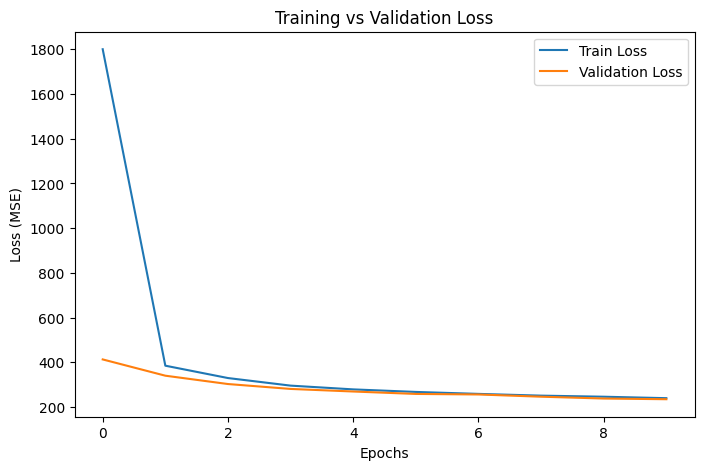

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Insights

- The training and validation MSE (Mean Squared Error) both decrease sharply in the first few epochs and then plateau, showing a healthy convergence with no significant overfitting.

- The small, consistent gap between training and validation losses indicates the model generalizes well from training to unseen validation data.

- This suggests effective learning and appropriate complexity for your ANN model.

### Model Diagnostics & Interpretation

####  Error Analysis by Key Dimensions
Analyze prediction errors grouped by hour, day of week, and zones.

In [54]:
val_df = df.loc[X_val.index].copy()
val_df['predicted_ride_count'] = val_preds.flatten()
val_df['error'] = val_df['ride_count'] - val_df['predicted_ride_count']

# Group by hour
hour_errors = val_df.groupby('hour')['error'].mean()
hour_abs_errors = val_df.groupby('hour')['error'].apply(lambda x: x.abs().mean())

# Group by day of week
dow_errors = val_df.groupby('day_of_week')['error'].mean()
dow_abs_errors = val_df.groupby('day_of_week')['error'].apply(lambda x: x.abs().mean())

# Group by PULocationID (top zones only)
top_zones = val_df['PULocationID'].value_counts().nlargest(10).index
zone_errors = val_df[val_df['PULocationID'].isin(top_zones)].groupby('PULocationID')['error'].mean()
zone_abs_errors = val_df[val_df['PULocationID'].isin(top_zones)].groupby('PULocationID')['error'].apply(lambda x: x.abs().mean())

#### Visualize Errors

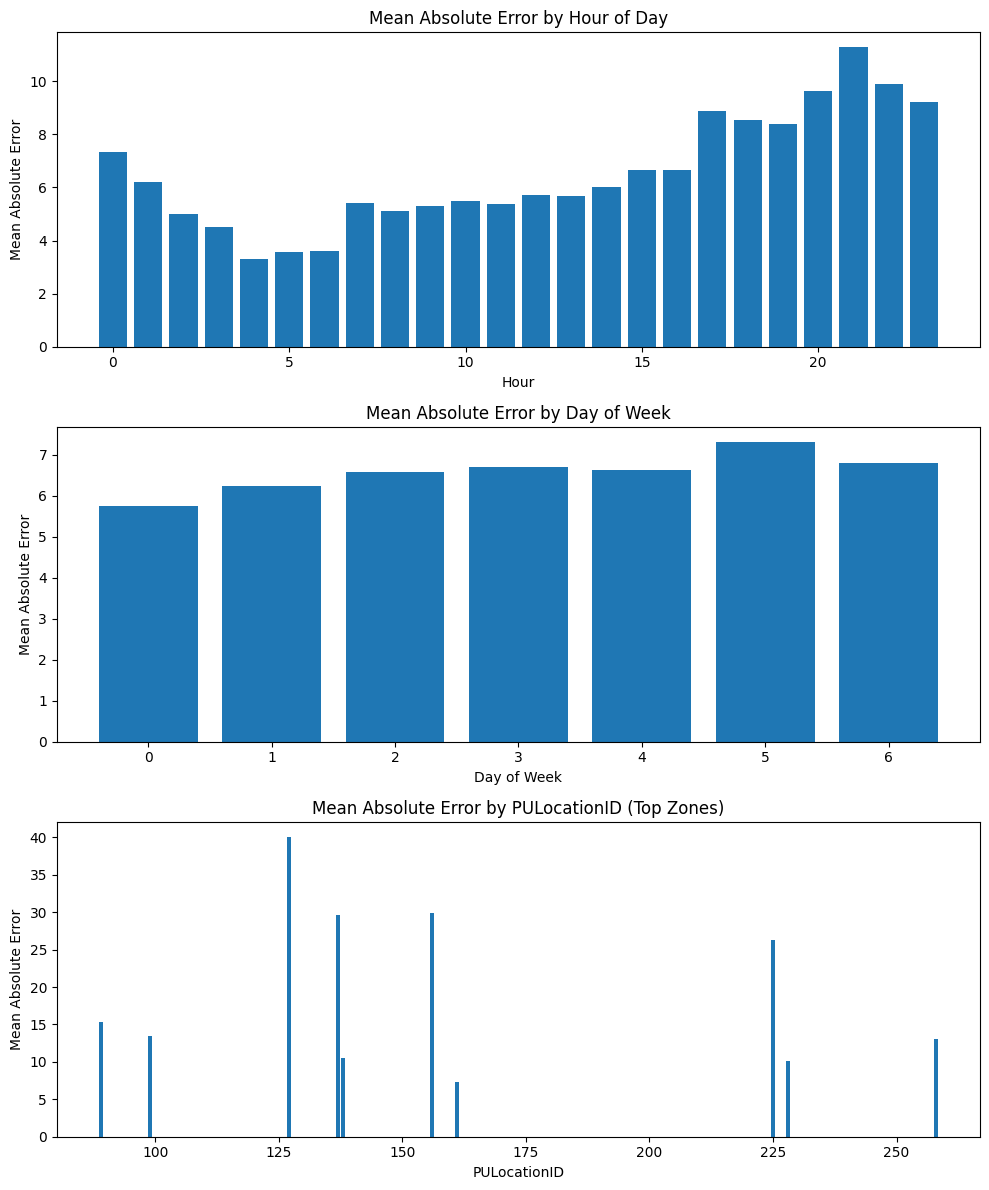

In [57]:
fig, axs = plt.subplots(3, 1, figsize = (10, 12))

axs[0].bar(hour_errors.index, hour_abs_errors)
axs[0].set_title('Mean Absolute Error by Hour of Day')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Mean Absolute Error')

axs[1].bar(dow_errors.index, dow_abs_errors)
axs[1].set_title('Mean Absolute Error by Day of Week')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Mean Absolute Error')

axs[2].bar(zone_errors.index, zone_abs_errors)
axs[2].set_title('Mean Absolute Error by PULocationID (Top Zones)')
axs[2].set_xlabel('PULocationID')
axs[2].set_ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()

### Insights


- <b>Mean Absolute Error by Hour of Day</b>
    - The model performs best in the early morning through midday, with MAE as low as 3–5.

    - Error increases steadily later in the day, peaking in the late evening (20:00–23:00) with MAE around 10–12.

    - Evening periods may have more unpredictable demand surges or outlier events, making them harder for the model to predict accurately.


- <b>Mean Absolute Error by Day of Week</b>
    - MAE is relatively stable (5–7) across all days, with a slight uptick late in the week (Fridays and Saturdays).

    - Weekly trends are learned well, but the minor increase suggests slightly more irregular demand on weekends.


- <b>Mean Absolute Error by Pickup Zone (Top Zones Only)</b>
    - Significant variation in MAE between zones, ranging from under 10 to about 40 in certain high-traffic locations.

    - Higher error in some zones (e.g., zones with IDs around 125–150) implies these are either very busy, structurally different from the rest, or subject to special events or conditions not captured by current features.

    - Opportunity to further improve model by incorporating zone-specific features or external event data.

### Fine-Tuning and Model Improvement

#### Define a Model-Building Function with Hyperparameters

In [60]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    inputs = {}
    embeddings = []

    cat_features = ['PULocationID', 'weathercode', 'hour', 'day_of_week', 'month']

    # Tune embedding sizes between 2 and 50
    for col in cat_features:
        inputs[col] = Input(shape = (1, ), name = col)
        emb_dim = hp.Int(f"emb_dim{col}", min_value = 2, max_value = 50, step = 2)
        emb = Embedding(input_dim = df[col].nunique() + 1, output_dim = emb_dim, name = f"emn_{col}")(inputs[col])
        embeddings.append(Flatten()(emb))

    # Numerical features
    numeric_cols = ['is_weekend', 'is_holiday', 'temperature_2m', 'precipitation',
                    'ride_count_lag_1', 'ride_count_lag_24', 'ride_count_lag_168',
                    'ride_count_roll_mean_3', 'ride_count_roll_std_3']
    numeric_inputs = Input(shape = (len(numeric_cols), ), name = 'numeric_inputs')
    embeddings.append(numeric_inputs)

    x = Concatenate()(embeddings)

    # Tune number of dense layers: 1 to 3
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        units = hp.Int(f"dense_units_{i}", min_value = 32, max_value = 256, step = 32)

        x = Dense(units, activation = 'relu')(x)

        # tune Dropout
        if hp.Boolean(f"dropout_{i}"):
            rate = hp.Float(f"dropout_rate{i}", 0.1, 0.5, step = 0.1)
            x = Dropout(rate)(x)
    
    output = Dense(1, activation = 'linear')(x)

    model = Model(inputs = [*inputs.values(), numeric_inputs],  outputs = output)

    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log')
    model.compile(optimizer = Adam(learning_rate = lr), loss = 'mse', metrics = ['mae'])

    return model

#### Define the Tuner and Start Search


In [61]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 20,
    executions_per_trial = 1, 
    directory = 'tuner_dir',
    project_name = 'taxi_demand_forecasting'
)

# Run search (adjust epochs and batch size as needed)
tuner.search(train_inputs, y_train.values, validation_data= (val_inputs, y_val.values), epochs = 10, batch_size = 1024)

Trial 20 Complete [00h 00m 32s]
val_loss: 1638.4034423828125

Best val_loss So Far: 175.1700897216797
Total elapsed time: 00h 09m 28s


#### Retrieve the Best Model and Hyperparameters

In [64]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print("Best embedding sizes and architecture found:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best embedding sizes and architecture found:
emb_dimPULocationID: 48
emb_dimweathercode: 2
emb_dimhour: 20
emb_dimday_of_week: 10
emb_dimmonth: 20
num_dense_layers: 2
dense_units_0: 192
dropout_0: False
learning_rate: 0.0035065850163276276
dense_units_1: 32
dropout_1: False
dense_units_2: 192
dropout_2: True
dropout_rate1: 0.2
dropout_rate2: 0.2
dropout_rate0: 0.30000000000000004


### Test the Best Model and Validate Improvements

#### Evaluate the Best Model on Validation Set

In [77]:
val_predictions = best_model.predict(val_inputs)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_new = mean_absolute_error(y_val, val_predictions)
mse_new = mean_squared_error(y_val, val_predictions)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_val, val_predictions)

print(f"Mean Absolute Error (MAE): {mae_new}")
print(f"Mean Squared Error (MSE): {mse_new}")
print(f"Root Mean Squared Error (RMSE): {rmse_new}")
print(f"R-squared (R2): {r2_new}")

2014/2014 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Absolute Error (MAE): 5.697754383087158
Mean Squared Error (MSE): 175.17007446289062
Root Mean Squared Error (RMSE): 13.235183204734668
R-squared (R2): 0.9687907695770264


#### Compare best model with Iniitial Model

In [78]:
# Make a dataframe to compare with initial model
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Initial Model': [mae, mse, rmse, r2],
    'Tuned Model': [mae_new, mse_new, rmse_new, r2_new]
})

In [79]:
comparison_df

,Metric,Initial Model,Tuned Model
0,MAE,6.583485,5.697754
1,MSE,234.880569,175.170074
2,RMSE,15.325814,13.235183
3,R2,0.958152,0.968791


### Visualize Comparison

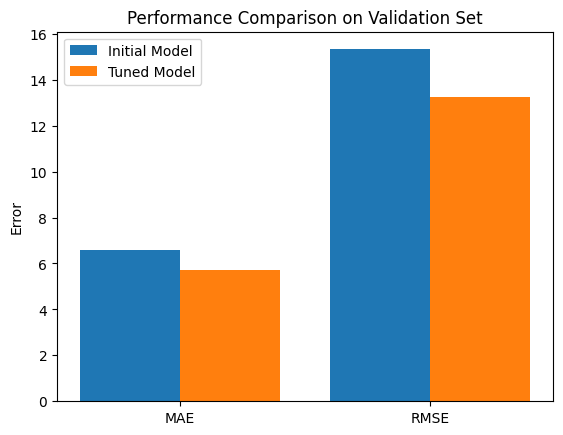

In [80]:
metrics = ['MAE', 'RMSE']
initial_scores = comparison_df[comparison_df['Metric'].isin(metrics)]['Initial Model'].values
tuned_scores = comparison_df[comparison_df['Metric'].isin(metrics)]['Tuned Model'].values

x = range(len(metrics))
plt.bar(x, initial_scores, width = 0.4, label = 'Initial Model', align = 'center')
plt.bar([p + 0.4 for p in x], tuned_scores, width = 0.4, label = 'Tuned Model', align = 'center')
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylabel('Error')
plt.title('Performance Comparison on Validation Set')
plt.legend()
plt.show()

### Retrain Model with Best Hyperparameters on Full Dataset

#### Combine Training and Validation Data

In [81]:
full_X = pd.concat([X_train, X_val], ignore_index=True)
full_y = pd.concat([y_train, y_val], ignore_index=True) 

full_inputs = create_model_inputs(full_X)

#### Rebuild Model with Best Hyperparameters

- Best Parameters:

    - Best embedding sizes and architecture found:
    - emb_dimPULocationID: 48
    - emb_dimweathercode: 2
    - emb_dimhour: 20
    - emb_dimday_of_week: 10
    -emb_dimmonth: 20
    - num_dense_layers: 2
    - dense_units_0: 192
    - dropout_0: False
    - learning_rate: 0.0035065850163276276
    - dense_units_1: 32
    - dropout_1: False
    - dense_units_2: 192
    - dropout_2: True
    - dropout_rate1: 0.2
    - dropout_rate2: 0.2
    - dropout_rate0: 0.30000000000000004

In [82]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [92]:
def build_final_model(best_hps):
    inputs = {}
    embeddings = []

    cat_features = ['PULocationID', 'weathercode', 'hour', 'day_of_week', 'month']

    for col in cat_features:
        inputs[col] = Input(shape = (1,), name = col)
        emb_dim = best_hps.get(f"emb_dim{col}")
        emb = Embedding(input_dim = df[col].nunique() + 1, output_dim = emb_dim, name = f"emb_{col}")(inputs[col])
        embeddings.append(Flatten()(emb))

    numeric_cols = ['is_weekend', 'is_holiday', 'temperature_2m', 'precipitation',
                    'ride_count_lag_1', 'ride_count_lag_24', 'ride_count_lag_168',
                    'ride_count_roll_mean_3', 'ride_count_roll_std_3']
    numeric_inputs = Input(shape = (len(numeric_cols), ), name = 'numeric_inputs')
    embeddings.append(numeric_inputs)
    
    x = Concatenate()(embeddings)
    num_dense_layers = best_hps.get('num_dense_layers')
    for i in range(num_dense_layers):
        units = best_hps.get(f'dense_units_{i}')
        x = Dense(units, activation = 'relu')(x)
        if best_hps.get(f'dropout_{i}'):
            rate = best_hps.get(f'dropout_rate{i}')
            x = Dropout(rate)(x)

    output = Dense(1, activation = 'linear')(x)

    model = Model(inputs = [*inputs.values(), numeric_inputs], outputs = output)

    lr = best_hps.get('learning_rate')
    model.compile(optimizer = Adam(learning_rate = lr), loss = 'mse', metrics = ['mae'])

    return model

In [94]:
final_model = build_final_model(best_hps)
final_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ PULocationID        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weathercode         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_of_week         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ month (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_PULocationID    │ (None, 1, 48)     │     12,576 │ PULocationID[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_weathercode     │ (None, 1, 2)      │         28 │ weathercode[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_hour            │ (None, 1, 20)     │        500 │ hour[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_day_of_week     │ (None, 1, 10)     │         80 │ day_of_week[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_month           │ (None, 1, 20)     │         80 │ month[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 48)        │          0 │ emb_PULocationID… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 2)         │          0 │ emb_weathercode[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 20)        │          0 │ emb_hour[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 10)        │          0 │ emb_day_of_week[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 20)        │          0 │ emb_month[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 109)       │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0], │
│                     │                   │            │ flatten_22[0][0]

 Total params: 40,593 (158.57 KB)

 Trainable params: 40,593 (158.57 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
final_model.fit(full_inputs, full_y.values, epochs = 10, batch_size = 1024)

Epoch 1/10
304/315 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1927.2211 - mae: 17.0928

2025-08-20 23:40:22.653574: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 23:40:22.653655: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 23:40:22.653716: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-20 23:40:23.315842: I external/l

315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 780.5182 - mae: 10.7267
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 257.9536 - mae: 6.8491
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 225.8413 - mae: 6.4664
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 207.1425 - mae: 6.2114
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 194.6640 - mae: 6.0306
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 187.0358 - mae: 5.9393
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 180.4077 - mae: 5.8509
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 173.0286 - mae: 5.7414
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 166.3683 - mae: 5.6458
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 162.7699 - mae: 5.5987


### Let us save the final model

In [101]:
import pickle
import os

os.makedirs('models', exist_ok=True)
## Save the encoders and scaler
with open('models/label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)
    
with open('models/standard_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
## Save the model
final_model.save("models/taxi_demand_forecasting_model.keras")